# Server-Side Code

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import tensorflow as tf

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

### Inference Model

In [15]:
# Half of the Inference Model Stored on Server Side
class ServerResnet(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(ServerResnet, self).__init__(*args, **kwargs)
        
        # Load ResNet50 pre-trained model without top (fully connected) layers
        resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        resnet_base.trainable = False
        
        # Get the output of the last two convolutional layer before Pooling
        middle_layer = resnet_base.get_layer('conv3_block4_out')
        last_conv_layer = resnet_base.get_layer('conv5_block3_out')

        self.seq1 = tf.keras.Sequential([
            Model(inputs=middle_layer.output, outputs=last_conv_layer.output),
            tf.keras.layers.GlobalMaxPooling2D(),
        ])

    # Forward pass of the server model
    def predict(self, inputs):
        server_embeddings = self.seq1(inputs)

        # Normalize data
        flatten_result = tf.keras.layers.Flatten()(server_embeddings)
        result_normalized = flatten_result / la.norm(flatten_result)
        return result_normalized[0]

In [67]:
# Replace: This is a mimic for recieving from client
client_embeddings = np.load("client_embeddings.npy")

# Load in model and perform inference
ServerModel = ServerResnet()
server_embeddings = ServerModel.predict(client_embeddings)

server_embeddings

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([0.02651525, 0.073531  , 0.        , ..., 0.        , 0.00534359,
       0.01297403], dtype=float32)>

### Neighbor Search

In [46]:
# Data paths
data_dir = "../polyvore_outfits/"
images_path = data_dir + "images/"

# Load in embeddings
embeddings_path = data_dir + "embeddings.npy"
embeddings = np.load(embeddings_path)

# Load in filenames
filenames_path = data_dir + "filenames.txt"
filenames_file = open(filenames_path, 'r')
filenames = [line.strip() for line in filenames_file.readlines()]

# Error checking for embeddings + filenames
if len(embeddings) != len(filenames):
    print("STOP. The lengths of embeddings and filenames don't match")
    print(len(embeddings), len(filenames))

# Create nearest neighbor search for embeddings
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(embeddings)


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [25]:
# Load in outfits metadata
outfits_metadata_path = data_dir + "outfits_metadata.json"
outfits_file = open(outfits_metadata_path, 'r')
outfit_map = json.load(outfits_file)

# Load in item (clothing) metadata
item_metadata_path = data_dir + "item_metadata.json"
items_file = open(item_metadata_path, 'r')
items_map = json.load(items_file)

# Inverted index from image to boards they are part of
item_to_outfits = {}
for outfit_id, metadata in outfit_map.items():
    for item in metadata['items']:
        item_id = item['item_id']
        item_to_outfits[item_id] = item_to_outfits.get(item_id, []) + [outfit_id]
        

### Display Results

In [61]:
def displayBoard(key):
    # Size hyperparameters
    num_items = len(outfit_map[key]['items'])
    image_width = 300

    # Loop through image items
    concatenated_image = np.zeros((image_width, 0, 3), dtype=np.uint8)
    item_descriptions = []
    for ids in outfit_map[key]['items']:
        path = "../polyvore_outfits/images/" + ids['item_id'] + ".jpg"
        image = Image.open(path)

        image = image.resize((image_width, image_width), Image.LANCZOS)
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

        description = items_map[ids['item_id']]['url_name'] + " (" + items_map[ids['item_id']]['semantic_category'] + ")"
        item_descriptions.append(description)

    # Display board
    plt.figure(figsize=(image_width * num_items / 100, image_width / 100))  # Adjusted figure size
    plt.imshow(concatenated_image)
    plt.axis('off')

    plt.show()

In [65]:
distance, indices = neighbors.kneighbors([server_embeddings])
html_string, boards = "", []

# Display similar items
for file_idx in indices[0]:
    # Load in images
    img = Image.open(images_path + filenames[file_idx])
    img_tag = f"<img src='{images_path + filenames[file_idx]}' style='width:{100}px;height:{100}px;margin:0;padding:0;'>"
    html_string += img_tag

    # Get boards for associated images
    img_path = filenames[file_idx][:-4]
    img_board = item_to_outfits.get(img_path, [])
    boards.extend(img_board)
    
from IPython.display import display, HTML
display(HTML(html_string))

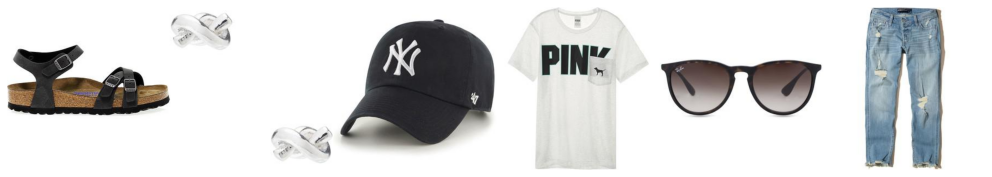

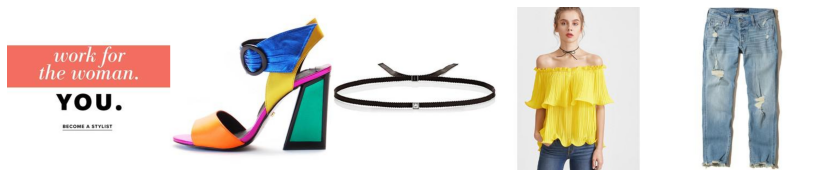

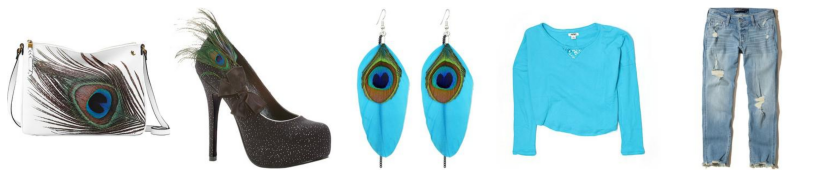

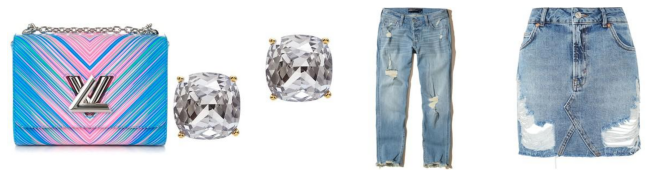

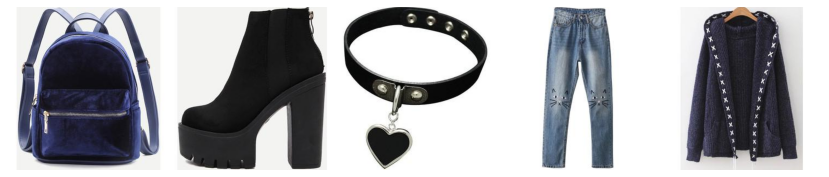

In [66]:
# Display similar boards
for board in boards:
    displayBoard(board)